# AdaFlix Milestone 3

# Imports, loading and downloads

In [1]:
#! pip install spacy
#!pip install -U textblob
#!pip install --user -U nltk
# !python -m spacy download en_core_web_sm

In [2]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import nltk
import spacy
import string
from scipy import stats
from textblob import TextBlob
from collections import Counter
from nltk.sentiment.util import *
from nltk.corpus import stopwords
from sklearn import preprocessing
import sklearn.ensemble as ske
from nltk.corpus import subjectivity
from nltk.tokenize import word_tokenize
from spacy.lang.en.examples import sentences
from nltk.sentiment import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scripts.helper import *
from scripts.plot import *
from loads import *
import os

In [3]:

nltk.download('punkt')
nltk.download('stopwords')
# nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))
stop_words.add(string.punctuation)

PATH_FOLDER = "MovieSummaries/"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\41794\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\41794\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
# Loading character metadata DataFrame
character_df = load_character_metadata()
# Loading movie metadata DataFrame
movie_df = load_movie_metadata()
# Loading plot summaries DataFrame
plot_summaries_df = load_plot_summaries()
# Loading TVTropes DataFrame
tvtropes_df = load_tvtropes()
# Loading name clusters DataFrame
name_clusters_df = load_name_clusters()
# Load external df, for more details run the scripts/html_parser_oussama.ipynb
external_df = pd.read_csv("external_dataset/boxofficemojo_dataframe.csv")
# Loading inflation DataFrame
inflation = pd.read_excel("external_dataset/inflation.xlsx", header=11)

C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# Preprocessing

## Movie Cleaning

We are first extracting variables that have the form (ID : variable) tuples to be able to use these features.

In [69]:
# Extracting and transforming the 'Movie languages (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of language names
movie_df['Movie_Languages'] = movie_df['Movie languages (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))
# Extracting and transforming the 'Movie countries (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of country names
movie_df['Movie_Countries'] = movie_df['Movie countries (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))
# Extracting and transforming the 'Movie genres (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of genre names
movie_df['Movie_Genres'] = movie_df['Movie genres (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))

A lot of columns in the dataframe contain IDs that we don't need, we are thus dropping them.

In [70]:
# List of columns to be dropped from the DataFrame
movie_columns_to_drop = ['Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)','Movie genres (Freebase ID:name tuples)','Freebase movie ID']
# Dropping specified columns from the DataFrame
movie_df.drop(movie_columns_to_drop, axis=1, inplace=True)

Let's first check the number of missing values (Nan), in each column.

In [7]:
# Check the number of Nans in each column
print(movie_df.isna().mean())

Wikipedia_movie_ID          0.000000
Movie_name                  0.000000
Movie_release_date          0.084437
Movie_box_office_revenue    0.897224
Movie_runtime               0.250180
Movie_Languages             0.000000
Movie_Countries             0.000000
Movie_Genres                0.000000
dtype: float64


We can see that 89% of the revenues are missing. Our main interest is to study what feature result in high box office revenues, so we will need to drop the missing revenues.

In [71]:
# Dropping rows from the DataFrame where 'Movie box office revenue' is NaN
movie_df.dropna(subset=['Movie_box_office_revenue'], inplace=True)

Since we will only consider revenues scaled according to inflation, we can already drop the NaN values from the 'Movie release date' column (we need them to compute the new revenues).

In [72]:
# Dropping rows where 'Movie release date' is NaN
movie_df.dropna(subset=["Movie_release_date"], inplace=True)

The remaining columns containing NaN values will be addressed individually later in the code. Dropping all NaN values at this point would result in the loss of information with respect to other columns that do not contain NaN values.

One of our feature of interest is the release date of the movies. We are thus, processing the column, for it to be usable in our analysis. We extract Year and Month from the Movie release date (date format YYYY and YYYY-MM-DD can't be dealt together).

In [73]:
# Create a Year column in the movie dataframe
movie_df['Year'] = movie_df["Movie_release_date"].apply(lambda x: str(x)[:4]).astype(int)
# Create a Month column in the movie dataframe
movie_df['Month'] = pd.to_datetime(movie_df['Movie_release_date'],errors='coerce').dt.month

## Inflation and box office revenues distribution

To be able to compare the relative box office revenues across different years, we need to take inflation into account.

In [74]:
# Calculate cumulative inflation to 2022 using the last available annual inflation rate
inflation["Cumulative Inflation to 2022"] = inflation.iloc[-1].Annual / inflation["Annual"]
# Merge the movie DataFrame with the inflation DataFrame on the 'Year' column
movie_with_inflation = pd.merge(movie_df, inflation, on='Year')
# Calculate revenue with inflation by multiplying 'Movie box office revenue' with the 'Cumulative Inflation to 2022'
movie_with_inflation['Revenue_with_inflation'] = movie_with_inflation['Movie_box_office_revenue'] * movie_with_inflation['Cumulative Inflation to 2022']
# Calculate log of revenue with inflation
movie_with_inflation['log_revenues'] = np.log(movie_with_inflation['Revenue_with_inflation'])
# Drop unnecessary columns
movie_with_inflation.drop(['Cumulative Inflation to 2022', 'Annual'], axis=1, inplace=True)

# display(movie_with_inflation)

The original distribution of the inflated movie box office revenue exhibits a heavy-tailed pattern, with a few movies achieving extremely high revenues. By applying a logarithmic transformation on the x-axis, we "approximate" a normal distribution, making the data more amenable to statistical analyses that assume normality.

C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

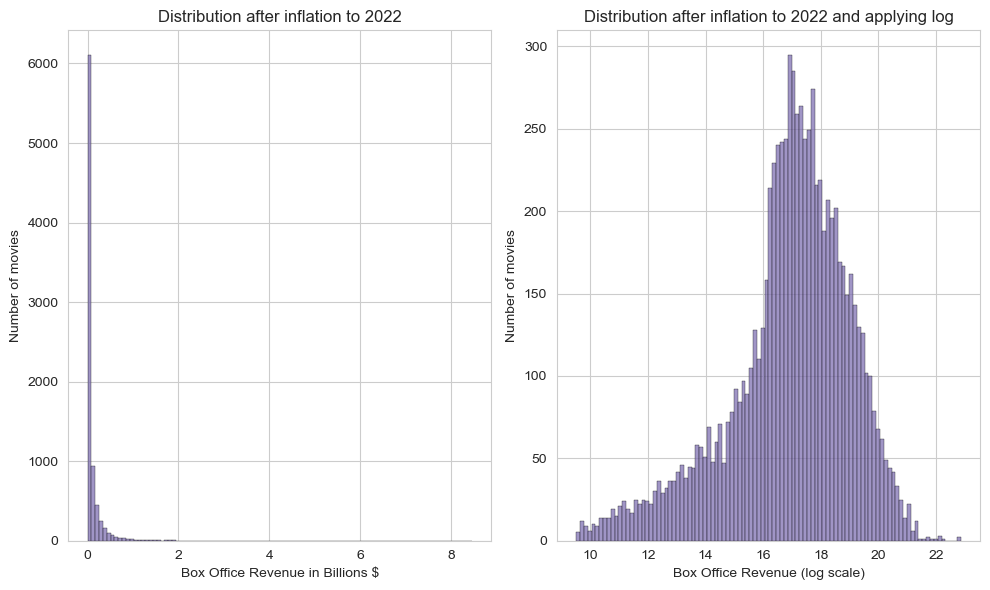

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Plotting the original distribution and the distribution after applying log function on the revenue feature
sns.histplot(data=movie_with_inflation, x=movie_with_inflation['Revenue_with_inflation']/1e9, bins=100, color=sns.color_palette("deep")[4], edgecolor='black', ax=ax1)
ax1.set(title='Distribution after inflation to 2022',
        xlabel='Box Office Revenue in Billions $',
        ylabel='Number of movies')

# Distribution after applying log
sns.histplot(data=movie_with_inflation, x='log_revenues', bins=100, edgecolor='black', color=sns.color_palette("deep")[4],ax=ax2)
ax2.set(title='Distribution after inflation to 2022 and applying log',
        xlabel='Box Office Revenue (log scale)',
        ylabel='Number of movies')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Now that we have seen that we should use logs, we can look at the effect of applying the inflation to the revenues across the years.

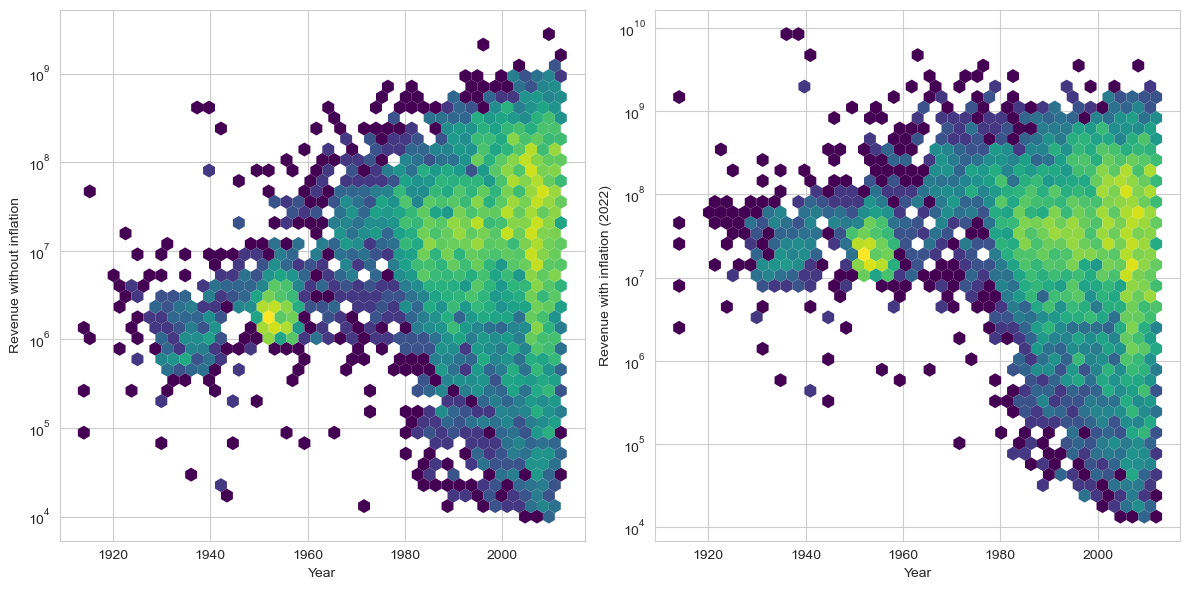

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot for Revenue without inflation
ax1.hexbin(movie_with_inflation['Year'], movie_with_inflation['Movie_box_office_revenue'], gridsize=40, bins='log', yscale='log', linewidths=0, cmap='viridis')
ax1.set_xlabel('Year')
ax1.set_ylabel('Revenue without inflation')

# Plot for Revenue with inflation
ax2.hexbin(movie_with_inflation['Year'], movie_with_inflation['Revenue_with_inflation'], gridsize=40, bins='log', yscale='log', linewidths=0, cmap='viridis')
ax2.set_xlabel('Year')
ax2.set_ylabel('Revenue with inflation (2022)')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

We can see that it has effectively highered older revenues, and it is actually resulting in a more similar distribution across the years. Two points to note :
    -the highest old revenues have now surpassed the other. The inflation had huge impact on them and made them outliers.
    -even the most recent revenues have been inflated since we are considering the inflation to 2022, to make it more reprensentative for us.

## Character Cleaning

Again, a lot of columns in the dataframe contain IDs that we don't need, as well as actors' heights, we are thus, dropping them.

In [75]:
# Dropping unnecessary character-related columns from the DataFrame
character_columns_to_drop = ['Freebase movie ID', 'Actor ethnicity (Freebase ID)','Freebase character ID','Freebase actor ID','Actor height (in meters)']
character_df.drop(character_columns_to_drop, axis=1, inplace=True)

As before, we will not drop all the NaNs right now, instead, missing values will be dealt with, once the dataset is split into smaller dataframes.

## Splitting

We are now splitting the dataframes into many small different dataframes for each feature. Each small dataframe has one feature, inflated box office revenue, and 'log_revenues'. These small dataframes are created for the analysis to be easier.

In [76]:
# Extracting 'Movie runtime' and revenue columns into a new dataframe
movie_runtime_df = movie_with_inflation[['Wikipedia_movie_ID','Movie_runtime','Revenue_with_inflation', 'log_revenues']].copy()
# Extracting 'Movie Languages' and revenue columns into a new dataframe
movie_languages_df = movie_with_inflation[['Wikipedia_movie_ID','Movie_Languages','Revenue_with_inflation', 'log_revenues']].copy()
# Extracting 'Movie Countries' and revenue columns into a new dataframe
movie_countries_df = movie_with_inflation[['Wikipedia_movie_ID','Movie_Countries', 'Revenue_with_inflation','log_revenues']].copy()
# Extracting 'Movie Genres' and revenue columns into a new dataframe
movie_genres_df = movie_with_inflation[['Wikipedia_movie_ID','Movie_Genres', 'Revenue_with_inflation','log_revenues']].copy()
# Extracting 'Month' and revenue columns into a new dataframe
months_df = movie_with_inflation[['Wikipedia_movie_ID','Month','Revenue_with_inflation', 'log_revenues']].copy()
# Extracting 'Year' and revenue columns into a new dataframe
years_df = movie_with_inflation[['Wikipedia_movie_ID','Year', 'Revenue_with_inflation','log_revenues']].copy()

Drop movies in each small dataframe, only for the missing values (Nan) of the concerned feature.

In [77]:
# Drop NaNs in each small dataframes
movie_runtime_df.dropna(subset=['Movie_runtime'], inplace=True)
movie_languages_df.dropna(subset=['Movie_Languages'], inplace=True)
movie_countries_df.dropna(subset=['Movie_Countries'], inplace=True)
movie_genres_df.dropna(subset=['Movie_Genres'], inplace=True)
years_df.dropna(subset=['Year'], inplace=True) #no nan but safer
months_df.dropna(subset=['Month'], inplace=True)

We then need to merge character and movie dataframes, to be able to extract information on actors and their impact on box office revenues

In [78]:
# Merging character_df and movie_with_inflation DataFrames on 'Wikipedia movie ID'
# Dropping the 'Movie release date' column from character_df to avoid duplicate columns after the merge
character_movie_merged_df = pd.merge(character_df.drop(['Movie_release_date'],axis=1), movie_with_inflation, on=['Wikipedia_movie_ID'])


One of our feature will be the percentage of actress in movies, so we need to get this information.

In [79]:
# Create a new DataFrame containing relevant columns from the original DataFrame
actor_gender_movie_df = character_movie_merged_df[['Wikipedia_movie_ID','Movie_name','log_revenues','Actor_name','Actor_gender','Revenue_with_inflation']].copy()
# Drop rows with missing values
actor_gender_movie_df.dropna(inplace=True)
# Compute percentage of women in each movies
actor_gender_movie_df['Percentage_Women'] = (actor_gender_movie_df.groupby('Movie_name')['Actor_gender']
                                              .transform(lambda x: (x == 'F').mean() * 100)
                                              .fillna(0)  # Fill NaN with 0
                                              .astype(int)  # Ensure the column is of int type
                                             )

In [80]:
# Creating a DataFrame with actor gender, movie name, and log_revenues from the merged DataFrame
gender_df = actor_gender_movie_df[['Wikipedia_movie_ID','Percentage_Women','Movie_name','log_revenues','Revenue_with_inflation']].copy()
# Removing duplicate rows from actor_gender_df based on all columns
gender_df.drop_duplicates(inplace = True)
# Creating a new DataFrame with percentage women and log_revenues, dropping rows with missing percentage women
gender_df.dropna(subset=['Percentage_Women'], inplace=True)

In [81]:
# Creating a DataFrame with actor name, actor age at movie release, and log_revenues from the merged DataFrame
actor_df = character_movie_merged_df[['Wikipedia_movie_ID','Actor_name','Actor age at movie release','log_revenues','Revenue_with_inflation']].copy()
actor_df.dropna()

,Wikipedia_movie_ID,Actor_name,Actor age at movie release,log_revenues,Revenue_with_inflation
0,975900,Wanda De Jesus,42.0,16.957621,2.315268e+07
1,975900,Natasha Henstridge,27.0,16.957621,2.315268e+07
2,975900,Ice Cube,32.0,16.957621,2.315268e+07
3,975900,Jason Statham,33.0,16.957621,2.315268e+07
4,975900,Clea DuVall,23.0,16.957621,2.315268e+07
...,...,...,...,...,...
100848,6456053,Roland Culver,64.0,17.746917,5.097861e+07
100849,6456053,Michael Hordern,53.0,17.746917,5.097861e+07
100850,6456053,Reginald Beckwith,56.0,17.746917,5.097861e+07
100851,32837210,Gong Yoo,32.0,17.503715,3.997302e+07


# Feature selection and data analysis

In this section, we will perform offline feature selection. We will analyze each feature independently and check it is correlated with the box office revenues of the movies. This way, we can decide what feature we want to keep in the final formula for predicting a movie's success.

## Release month

We first check if there is a correlation between the release month of a movie and the box office revenue.

In [21]:
# Compute the correlation between release month and log revenues
stats.spearmanr(months_df['Month'], months_df['log_revenues'])

SignificanceResult(statistic=0.09366287903172422, pvalue=1.0366280870920575e-14)

By running the spearman correlation test, we can see that the pvalue << 0.05 which rejects the null hypothesis that the box office revenues and release month are uncorrelated. Investigating which months result in higher box office revenues is thus a good idea.

C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


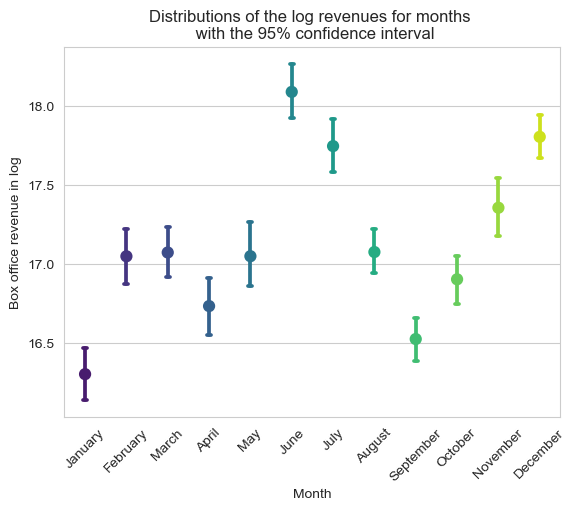

In [22]:
# boxplot of the revenues for each month
ax = sns.pointplot(x='Month', y='log_revenues', data=months_df, palette='viridis', capsize=0.1)
plt.title("Distributions of the log revenues for months \n with the 95% confidence interval")
plt.ylabel("Box office revenue in log")
plt.xlabel("Month")
# Customize x-axis labels
custom_labels = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October","November", "December"]
ax.set_xticklabels(custom_labels, rotation=45)
plt.show()

We observe that the best month to launch a movie is June, with a significant difference (no overlapping ci). It is followed by December and July. This pattern aligns with the months when students typically have vacations, which might explain the results.

In [23]:
# Declares the model
mod = smf.ols(formula='log_revenues ~ C(Month)', data=months_df)
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print the summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     39.34
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           3.89e-83
Time:                        13:45:14   Log-Likelihood:                -14339.
No. Observations:                6792   AIC:                         2.870e+04
Df Residuals:                    6780   BIC:                         2.878e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           16.3052      0.088  

The regression analysis confirms that the greatest coefficients are indeed the ones associated to June, July and December. In addition, the p_values associated to each of these months are smaller than 0.05, except for September, meaning that the coefficients are almost all statistically significant and that they probably all impact the box office revenue. We will thus take release months in our final formula for predicting a movie's success.

## Women percentage

We are now interested into the proportion of men and women actors in movies. We will analyze if there is a particular proportion that generally results in higher box office revenue. To this extend, we will analyze the percentage of actress in movies and how they relate to the box office revenues.

In [24]:
stats.spearmanr(gender_df['Percentage_Women'], gender_df['Revenue_with_inflation'])

SignificanceResult(statistic=-0.08966832643024661, pvalue=5.1617017932619725e-16)

Again, by running the spearman correlation test, we can see that the pvalue << 0.05 which rejects the null hypothesis that the box office revenues and percentage of women actresses are uncorrelated. We will thus further investigate this feature.

We will now perform an equal frequency discretization of the percentage of women, to divide percentages into 8 groups where we have an equal number of movies in each group. This way, instead of feeding the final formula with an actual percentage of women, we will feed it with categorical variables.

In [25]:
# Set number of groups
num_groups = 8
# Sort the DataFrame by 'Percentage_Women'
gender_df = gender_df.sort_values(by='Percentage_Women')

# Create bins based on quantiles
gender_df['group'] = pd.qcut(gender_df['Percentage_Women'], q=num_groups, labels=False, duplicates='drop')

# Display grouped summary
grouped_summary = gender_df.groupby('group').agg({'Percentage_Women': ['count', 'mean', 'min', 'max'],
                                                'log_revenues': 'mean'})
display(grouped_summary)

Percentage_Women                     log_revenues
                 count       mean min  max         mean
group                                                  
0                 1177   7.256585   0   14    16.889718
1                  894  18.029083  15   20    17.352263
2                 1034  23.864603  21   26    17.135323
3                 1569  30.563416  27   33    16.991490
4                  491  35.987780  34   37    17.233683
5                 1044  41.104406  38   44    16.949693
6                  958  48.669102  45   50    16.568074
7                  978  64.248466  51  100    16.505155

C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


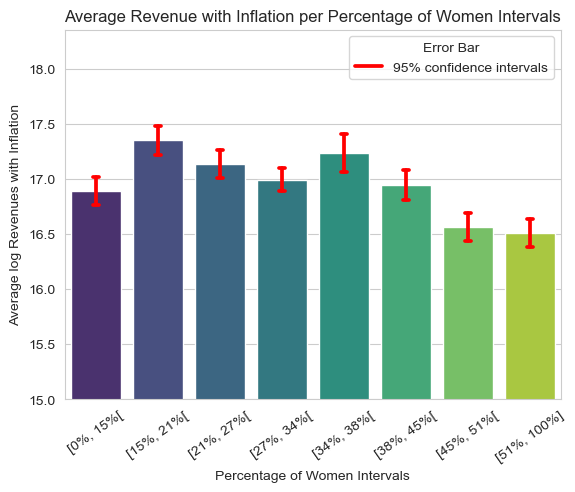

In [26]:
# Boxplot
ax = sns.barplot(x=gender_df['group'], y=gender_df['log_revenues'],palette='viridis', capsize=0.1, errcolor='red')

# Customize x-axis labels
custom_labels = ["[0%, 15%[", "[15%, 21%[", "[21%, 27%[", "[27%, 34%[", "[34%, 38%[", "[38%, 45%[","[45%, 51%[", "[51%, 100%]"]

ax.set_xticklabels(custom_labels, rotation=35)

plt.ylim(15, None)
plt.xlabel('Percentage of Women Intervals')
plt.ylabel('Average log Revenues with Inflation')
plt.title('Average Revenue with Inflation per Percentage of Women Intervals')

# Add legend
plt.legend(title='Error Bar', labels=['95% confidence intervals'])

plt.show()

From the plot, we can see that movies with women percentage between 15% and 21% result in significantly higher box office revenues, followed by movies that have women percentage of 34% to 38%. While movies with 45% to 100% have significantly lower mean box office revenues, and their confidence intervals don't intersect with other intervals.
We will now perform a regression analysis to better see if being in one of these groups have a significant impact on the box office. We will use the log revenues as the dependent variable.

In [27]:
# Declares the model
mod = smf.ols(formula='log_revenues ~ C(group)', data=gender_df)
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print the summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     17.97
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           7.38e-24
Time:                        13:45:15   Log-Likelihood:                -17622.
No. Observations:                8145   AIC:                         3.526e+04
Df Residuals:                    8137   BIC:                         3.532e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        16.8897      0.061    275.059

R squared = 0.021 confirms the small correlation between percentage of women and box office revenues, so taking the feature into account in the final formula is thus natural. The negative coefficients associated to the last two groups confirms our observation that having more than 45% of actress in a movie generally result in lower box office revenue. In addition, we can see that most of the p_values are smaller than 0.05, except for group 4 and 6.

## Release year

Let's now investigate the link between revenues and release year. We again perform discretization of the feature to use it as a categorical variable in the final formula. We will this time group years into chunks of size 10.

In [28]:
# Calculate the minimum and maximum years in the 'Year' column
min_year = years_df['Year'].min()
max_year = years_df['Year'].max()

# Create intervals of 10 years and assign labels based on the minimum and maximum years
years_df['year_intervals'] = pd.cut(years_df['Year'],
                                    bins=range(min_year, max_year + 11, 10),  # Define bins for 10-year intervals
                                    labels=[f"{start}-{start + 9}" for start in range(min_year, max_year, 10)],  # Create labels for intervals
                                    include_lowest=True)  # Include the lowest value in the interval

In [29]:
# Declares the model
mod = smf.ols(formula=' log_revenues ~ year_intervals', data=years_df)
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print the summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     44.74
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           3.53e-79
Time:                        13:45:15   Log-Likelihood:                -17952.
No. Observations:                8326   AIC:                         3.592e+04
Df Residuals:                    8316   BIC:                         3.599e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

We can see that none of these intervals have a p_value greater than 0.05. This suggests that there is no correlation between release year and box office revenues. This can be explained by the fact that we normalized revenues with inflation. However, we think that combining years with other features such as genre could still yield some interesting results, since different genres have been popular during different years. For this reason, we will take years in the final formula, even if it individually doesn't impact the box office.

## Actors

In [30]:
# Keep only the actors that appear in at least 20 movies
actors_in_20movies_df = actor_df.groupby('Actor_name').filter(lambda x: len(x) >= 20)

# display(actors_in_20movies_df)

In [31]:
# Sort the actors by the mean log_revenues of their movies (mean of log_revenues is equivalent to geometric mean of revenues)
top_actors = actors_in_20movies_df.groupby('Actor_name').mean('log_revenues').sort_values(by='log_revenues', ascending=False).reset_index()

#rescale log_revenues back to normal revenues (geometric mean)
top_actors['revenues_in_millions'] = np.exp(top_actors['log_revenues']) / 1e6

# display(top_actors)

In [32]:
top_actors.to_csv("csv_for_story/top_actors.csv")

C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


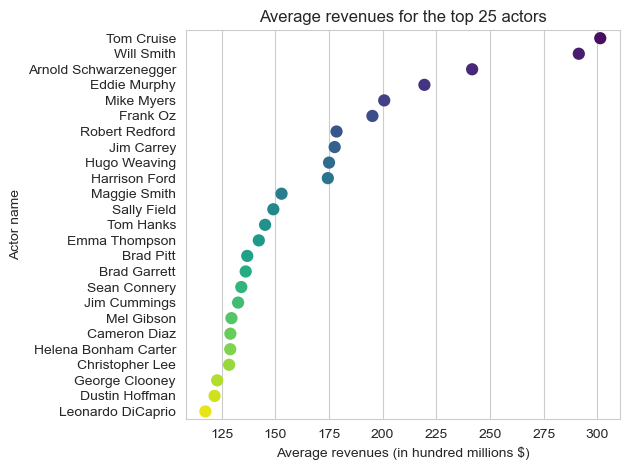

In [33]:
# Plot the mean
sns.pointplot(y='Actor_name', x='revenues_in_millions', data=top_actors.head(25), palette='viridis', errorbar=None)
plt.title('Average revenues for the top 25 actors')
plt.xlabel('Average revenues (in hundred millions $)')
plt.ylabel('Actor name')
plt.tight_layout()
plt.show()

**Important** Here as in many following feature analysis, we will be averaging log_revenues instead of revenues. This corresponds to computing the geometric mean instead of an arithmetic mean with the objective of gaining statistical stability:
The geometric mean tends to be less sensitive to extreme values (outliers) compared to the arithmetic mean. This makes it a more robust measure in situations where there are significant variations in the data , since it represent better the central tendency.
 In our case, it is  useful to penalize the big variances in revenues thus focusing on the consistency of the contribution of the analysed feature.

With geometric mean for actors, we are favoring those with consistent success over the ones who only participated in a few hits. A clear demonstration is that selecting the top actors with arithmetic mean was resulting in many actors from harry potter or other saga. This is because there are many film in these saga with high revenues, which was boosting the actors mean revenue despite them not having only nor much successful movies.

In [34]:
actor_reg = actors_in_20movies_df.drop(['Revenue_with_inflation'], axis=1)

In [35]:
model = smf.ols(formula='log_revenues ~ C(Actor_name)', data=actor_reg)
mod = model.fit()
print(mod.summary())


                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     2.589
Date:                Fri, 22 Dec 2023   Prob (F-statistic):           4.76e-82
Time:                        13:45:20   Log-Likelihood:                -36280.
No. Observations:               17352   AIC:                         7.379e+04
Df Residuals:                   16735   BIC:                         7.858e+04
Df Model:                         616                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [36]:
# select the top 5%, 20% and 50% actors
nbr_top_actors = len(top_actors)
top5_actors = top_actors.head(int(nbr_top_actors * 0.05))['Actor_name']
top20_actors = top_actors.head(int(nbr_top_actors * 0.2))['Actor_name']
top50_actors = top_actors.head(int(nbr_top_actors * 0.5))['Actor_name']

#take out top5 from top20 and top50, and top 20 from top50
top50_actors = top50_actors[~top50_actors.isin(top20_actors)]
top20_actors = top20_actors[~top20_actors.isin(top5_actors)]
top5_actors

0                Tom Cruise
1                Will Smith
2     Arnold Schwarzenegger
3              Eddie Murphy
4                Mike Myers
5                  Frank Oz
6            Robert Redford
7                Jim Carrey
8              Hugo Weaving
9             Harrison Ford
10             Maggie Smith
11              Sally Field
12                Tom Hanks
13            Emma Thompson
14                Brad Pitt
15             Brad Garrett
16             Sean Connery
17             Jim Cummings
18               Mel Gibson
19             Cameron Diaz
20     Helena Bonham Carter
21          Christopher Lee
22           George Clooney
23           Dustin Hoffman
24        Leonardo DiCaprio
25           Michael J. Fox
26               Chris Rock
27          Martin Lawrence
28       Pete Postlethwaite
29             Hugh Jackman
Name: Actor_name, dtype: object

In [37]:
# get rid of duplicates actor name for the same wikipedia movie id
actor_df = actor_df.drop_duplicates(subset=['Wikipedia_movie_ID', 'Actor_name'])
actor_df

,Wikipedia_movie_ID,Actor_name,Actor age at movie release,log_revenues,Revenue_with_inflation
0,975900,Wanda De Jesus,42.0,16.957621,2.315268e+07
1,975900,Natasha Henstridge,27.0,16.957621,2.315268e+07
2,975900,Ice Cube,32.0,16.957621,2.315268e+07
3,975900,Jason Statham,33.0,16.957621,2.315268e+07
4,975900,Clea DuVall,23.0,16.957621,2.315268e+07
...,...,...,...,...,...
100848,6456053,Roland Culver,64.0,17.746917,5.097861e+07
100849,6456053,Michael Hordern,53.0,17.746917,5.097861e+07
100850,6456053,Reginald Beckwith,56.0,17.746917,5.097861e+07
100851,32837210,Gong Yoo,32.0,17.503715,3.997302e+07


In [38]:
# for each film, count the number of actors that are in top5, top20 and top50

movie_top5_actors = actor_df.groupby('Wikipedia_movie_ID').agg({'Actor_name': lambda x: x.isin(top5_actors).sum()})\
    .reset_index().rename(columns={'Actor_name': 'top5_actors'})
movie_top20_actors = actor_df.groupby('Wikipedia_movie_ID').agg({'Actor_name': lambda x: x.isin(top20_actors).sum()})\
    .reset_index().rename(columns={'Actor_name': 'top20_actors'})
movie_top50_actors = actor_df.groupby('Wikipedia_movie_ID').agg({'Actor_name': lambda x: x.isin(top50_actors).sum()})\
    .reset_index().rename(columns={'Actor_name': 'top50_actors'})

movie_actors_df = pd.merge(movie_top5_actors, movie_top20_actors, on='Wikipedia_movie_ID')
movie_actors_df = pd.merge(movie_actors_df, movie_top50_actors, on='Wikipedia_movie_ID')

In [39]:
movie_actors_reg = pd.merge(movie_actors_df, movie_with_inflation, on='Wikipedia_movie_ID')
model = smf.ols(formula='log_revenues ~ top5_actors + top20_actors + top50_actors', data=movie_actors_reg)
mod = model.fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     531.4
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          1.84e-315
Time:                        13:45:26   Log-Likelihood:                -17019.
No. Observations:                8167   AIC:                         3.405e+04
Df Residuals:                    8163   BIC:                         3.407e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       16.3341      0.027    607.240   

## Movie runtime


We are first discretizing the movie runtime into meaningful fixed width intervals to break linearity and allow better interpretation of the results. This will also serve in the regression analysis later on.

In [40]:
# Define interval_range
movie_runtime_df['Interval'] = pd.cut(movie_runtime_df['Movie_runtime'], bins=[0, 60, 90, 120, 150, 180, 210, 240, 1100], labels=['0-1h', '1h-1h30', '1h30-2h', '2h-2h30', '2h30-3h', '3h-3h30', '3h30-4h', '4h+'])

# display(movie_runtime_df)

In [41]:
movie_runtime_df.to_csv("csv_for_story/movie_runtime.csv", index=False)

C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of obser

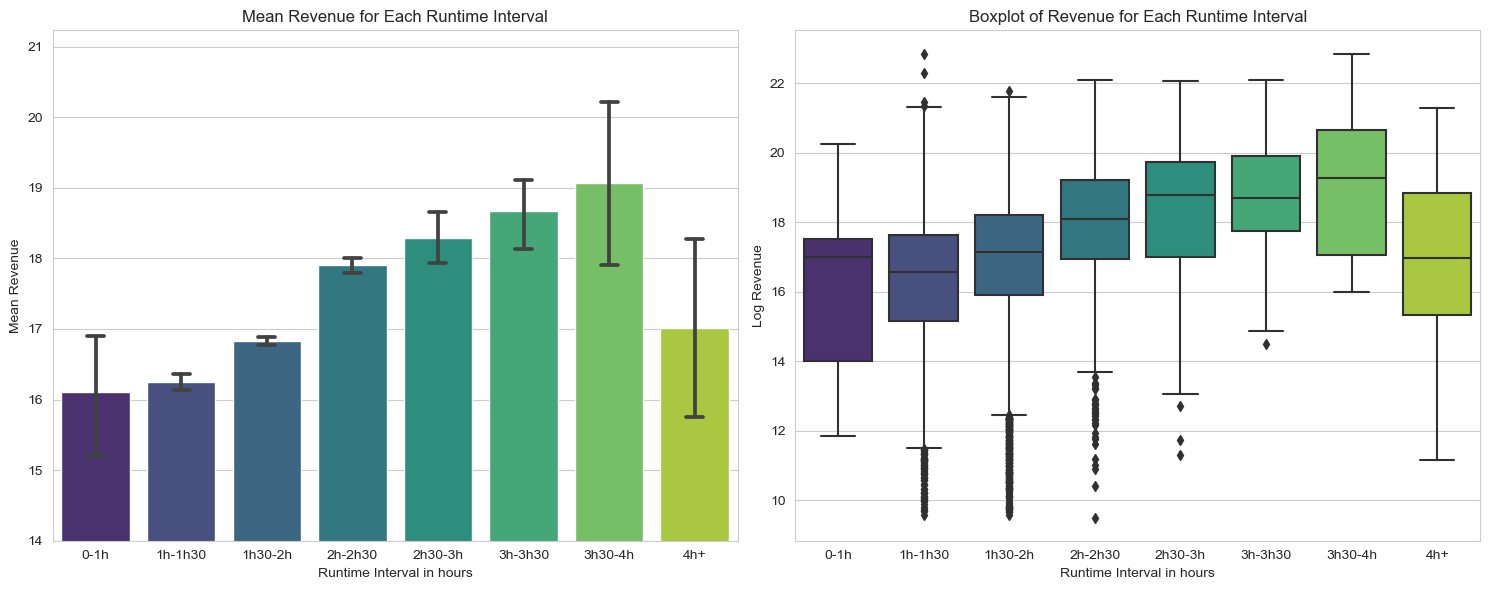

In [42]:
# Set up a multi-plot grid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the mean revenue with error bars and 95% confidence interval
sns.barplot(x='Interval', y='log_revenues', data=movie_runtime_df, capsize=.2, palette='viridis', ax=ax1)
ax1.set_title('Mean Revenue for Each Runtime Interval')
ax1.set_xlabel('Runtime Interval in hours')
ax1.set_ylabel('Mean Revenue')
#limit axis 1 to (14, none)
ax1.set_ylim(14, None)

# Plot the boxplot
sns.boxplot(x='Interval', y='log_revenues', data=movie_runtime_df, palette='viridis', ax=ax2)
ax2.set_title('Boxplot of Revenue for Each Runtime Interval')
ax2.set_xlabel('Runtime Interval in hours')
ax2.set_ylabel('Log Revenue')

plt.tight_layout()
plt.show()

## Movie genre

In [43]:
movie_genres_reg_df = disagregate_list_feature(movie_genres_df, 'Movie_Genres')
movie_genres_reg_df.drop(columns=['Revenue_with_inflation'], inplace=True)
movie_genres_reg_df

C:\Users\41794\Documents\ADA\Project\ada-2023-project-adaflix\loads.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[feature] = result_df[feature_name].apply(lambda x: feature in x)
C:\Users\41794\Documents\ADA\Project\ada-2023-project-adaflix\loads.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[feature] = result_df[feature_name].apply(lambda x: feature in x)
C:\Users\41794\Documents\ADA\Project\ada-2023-project-adaflix\loads.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usuall

,Wikipedia_movie_ID,log_revenues,News,British Empire Film,Comedy Thriller,Historical drama,Dogme 95,Gender Issues,Revisionist Fairy Tale,Action Thrillers,...,Swashbuckler films,Werewolf fiction,Buddy film,Pre-Code,Gay,Christian film,Sci-Fi Adventure,Steampunk,Historical Epic,Softcore Porn
0,975900,16.957621,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,156558,17.698161,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,5566878,15.838345,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,570743,18.583094,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,366111,19.267046,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8321,1995966,18.264864,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8322,24587655,16.970237,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8323,25721717,17.571717,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8324,171990,17.186055,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [44]:
#count number of movies for each country
genres_sum = movie_genres_reg_df.sum(axis=0)

#select genres with less than 200 movies
genres_not_many_movies = genres_sum[genres_sum <= 500]

# Merge all genres with less than 200 movies into one column "other"
movie_genres_reg_df['other_genres'] = np.where(movie_genres_reg_df[genres_not_many_movies.index].any(axis=1), True, False)

# Drop all genres with less than 200 movies
movie_genres_reg_df.drop(columns=genres_not_many_movies.index, inplace=True)

display(movie_genres_reg_df)

C:\Users\41794\AppData\Local\Temp\ipykernel_15136\2418812567.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  movie_genres_reg_df['other_genres'] = np.where(movie_genres_reg_df[genres_not_many_movies.index].any(axis=1), True, False)


,Wikipedia_movie_ID,log_revenues,Thriller,Crime Fiction,Drama,Period piece,Adventure,Romantic drama,Horror,Fantasy,...,Musical,Action/Adventure,Mystery,Science Fiction,World cinema,Family Film,Action,Comedy,Crime Thriller,other_genres
0,975900,16.957621,True,False,False,False,True,False,True,False,...,False,False,False,True,False,False,True,False,False,True
1,156558,17.698161,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,5566878,15.838345,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,True
3,570743,18.583094,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
4,366111,19.267046,False,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8321,1995966,18.264864,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
8322,24587655,16.970237,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
8323,25721717,17.571717,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
8324,171990,17.186055,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True


In [45]:
model = regression_analysis(movie_genres_reg_df, 'log_revenues')
genres_coefficients = pd.DataFrame({'Only genres': model.params})

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     117.4
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:45:30   Log-Likelihood:                -16932.
No. Observations:                8326   AIC:                         3.391e+04
Df Residuals:                    8301   BIC:                         3.409e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 16.8057      0

## Movie countries and languages

In [46]:
movie_countries_reg_df = disagregate_list_feature(movie_countries_df, 'Movie_Countries')
movie_countries_reg_df.drop(columns=['Revenue_with_inflation'], inplace=True)

In [47]:
#count number of movies for each country
countries_sum = movie_countries_reg_df.sum(axis=0)

#select countries with less than 200 movies
countries_not_many_movies = countries_sum[countries_sum <= 200]

# Merge all countries with less than 200 movies into one column "other"
movie_countries_reg_df['other_countries'] = np.where(movie_countries_reg_df[countries_not_many_movies.index].any(axis=1), True, False)

# Drop all countries with less than 200 movies
movie_countries_reg_df.drop(columns=countries_not_many_movies.index, inplace=True)

# display(movie_countries_reg_df)

In [48]:
model = regression_analysis(movie_countries_reg_df, 'log_revenues')
countries_coefficients = pd.DataFrame({'Only countries': model.params})

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     118.3
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          6.56e-210
Time:                        13:45:30   Log-Likelihood:                -17648.
No. Observations:                8326   AIC:                         3.532e+04
Df Residuals:                    8316   BIC:                         3.539e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [49]:
movie_languages_reg_df = disagregate_list_feature(movie_languages_df, 'Movie_Languages')
movie_languages_reg_df.drop(columns=['Revenue_with_inflation'], inplace=True)

C:\Users\41794\Documents\ADA\Project\ada-2023-project-adaflix\loads.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[feature] = result_df[feature_name].apply(lambda x: feature in x)
C:\Users\41794\Documents\ADA\Project\ada-2023-project-adaflix\loads.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[feature] = result_df[feature_name].apply(lambda x: feature in x)
C:\Users\41794\Documents\ADA\Project\ada-2023-project-adaflix\loads.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usuall

In [50]:
#count number of movies for each country
languages_sum = movie_languages_reg_df.sum(axis=0)

#select languages with less than 200 movies
languages_not_many_movies = languages_sum[languages_sum <= 200]

# Merge all languages with less than 200 movies into one column "other"
movie_languages_reg_df['other_languages'] = np.where(movie_languages_reg_df[languages_not_many_movies.index].any(axis=1), True, False)

# Drop all languages with less than 200 movies
movie_languages_reg_df.drop(columns=languages_not_many_movies.index, inplace=True)

# display(movie_languages_reg_df)

C:\Users\41794\AppData\Local\Temp\ipykernel_15136\3913596898.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  movie_languages_reg_df['other_languages'] = np.where(movie_languages_reg_df[languages_not_many_movies.index].any(axis=1), True, False)


In [51]:
model = regression_analysis(movie_languages_reg_df, 'log_revenues')
languages_coefficients = pd.DataFrame({'Only languages': model.params})

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     108.9
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          1.13e-193
Time:                        13:45:31   Log-Likelihood:                -17685.
No. Observations:                8326   AIC:                         3.539e+04
Df Residuals:                    8316   BIC:                         3.546e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 16.3110      0

Combining genres and countries in one model

In [52]:
# merge regression df on index
languages_countries_reg_df = pd.merge(movie_languages_reg_df, movie_countries_reg_df, left_index=True, right_index=True)
languages_countries_reg_df.drop(columns='log_revenues_y', inplace=True)

In [53]:
model = regression_analysis(languages_countries_reg_df, 'log_revenues_x')
languages_countries_coefficients = pd.DataFrame({'Languages and Countries': model.params})

                            OLS Regression Results                            
Dep. Variable:         log_revenues_x   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     76.04
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          3.81e-245
Time:                        13:45:31   Log-Likelihood:                -17547.
No. Observations:                8326   AIC:                         3.513e+04
Df Residuals:                    8308   BIC:                         3.526e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Ploting independent vs correlated coefficients

In [54]:
languages_plot = pd.merge(languages_coefficients, languages_countries_coefficients, left_index=True, right_index=True)
languages_plot = languages_plot.drop('const').sort_values(by='Only languages', ascending=False).transpose()
languages_plot = pd.melt(languages_plot.reset_index(), id_vars=['index'], var_name='languages', value_name='coef')

countries_plot = pd.merge(countries_coefficients, languages_countries_coefficients, left_index=True, right_index=True)
countries_plot = countries_plot.drop('const').sort_values(by='Only countries', ascending=False).transpose()
countries_plot = pd.melt(countries_plot.reset_index(), id_vars=['index'], var_name='countries', value_name='coef')

C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

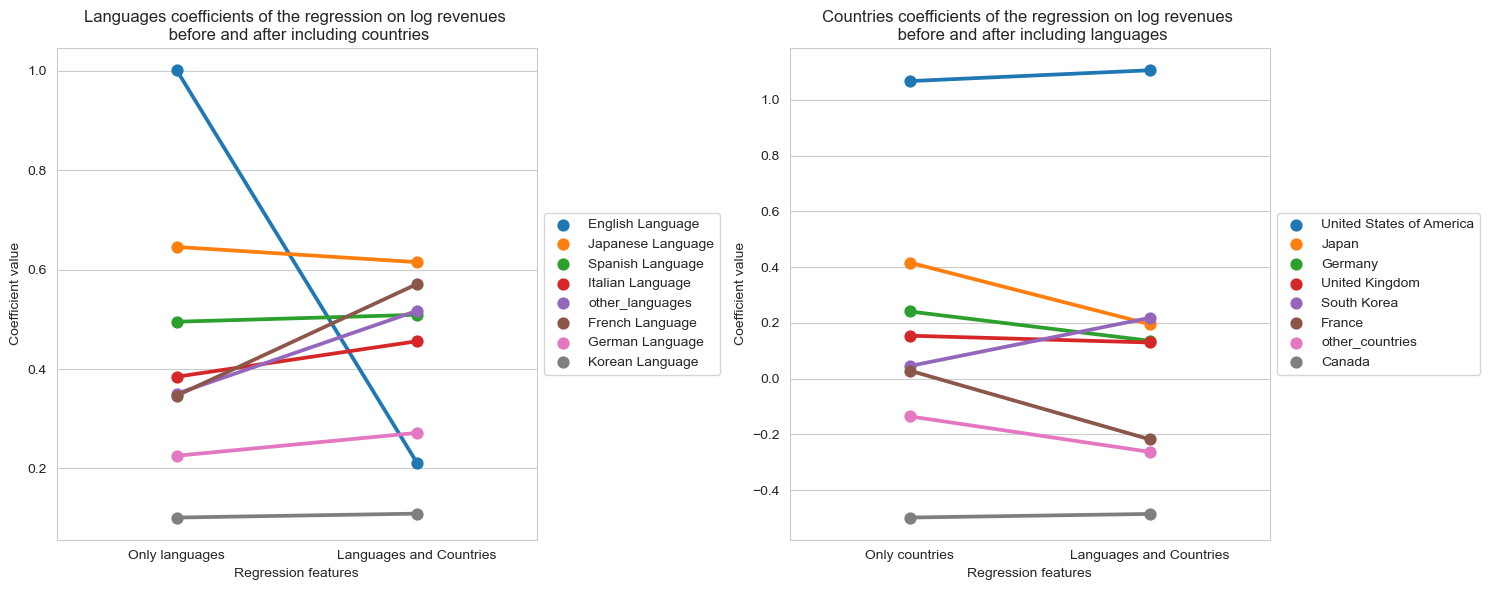

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.pointplot(data=languages_plot, x='index', y='coef', hue='languages', ax=ax1)
ax1.set(title='Languages coefficients of the regression on log revenues \n before and after including countries',
        xlabel='Regression features',
        ylabel='Coefficient value')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.pointplot(data=countries_plot, x='index', y='coef', hue='countries', ax=ax2)
ax2.set(title='Countries coefficients of the regression on log revenues \n before and after including languages',
        xlabel='Regression features',
        ylabel='Coefficient value')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


Since countries and languages are by essence correlated, we will analyze them together. The goal is first to see how relevant they are in the process of predicting the box office revenue individually, and then verify if they are actually both proxying the same information, meaning that we can only keep one of them in the final formula.

Before running the regression, we preprocessed the data by keeping only the countries or languages that appeared in at least 200 movies (approximately 2.5% of the movie analysed). The remaining countries and languages were grouped in a single category called "other".

When analysing each feature independently, the regressions resulted in a R-squared of 0.064 for countries and 0.059 for languages. It is low but still significant enough to considerate these features later in the formula. However, we must make sure that they aren't completely correlated, otherwise they would act as doubloons, and we would only keep one of them. Therefore we are running an other regression with both features. This -quite surprisingly- resulted in an R-squared of 0.094, which is a non-negligible increase of 50% to the previous results, indicating a partial but not total correlation between the two features. That said, we will include both features in the final formula.

Here is some possible interpretations of the result appearing in the plot. Note that these are only assumptions and that we would need further causal analysis to get more insights.

- When analysing features independently, US and english were high above the rest, and we would believe that they are both very impactful features on revenue. However, when analysing them together, we notice a big drop for english language, indicating that this feature was capturing a lot of information from the countries. We can imagine that it was benefiting from the success of the US, which is the biggest market for movies. On the other hand, US coefficient didn't change much, so it seems the defining factor isn't much the english language but rather the US market.
- Excluding the US, the average coefficient of the languages is higher than the average coefficient of the countries, indicating that languages are a better indicator of revenue than countries.
- Combined, english isn't even first anymore and has been doubled by french that encountered the highest increase across all languages. Yet, France is also the country that lowered the most. In the global growth of languages and decrease of countries, France and french was affected the most

## Sentiment Analysis

In this section we will perform sentiment analysis on the movie summaries. Namely, we will see if there is a link between the percentage of positive / negative words present in movie summaries and the revenues.

In [82]:
movie_summaries = plot_summaries_df.copy()

#Extract each column in a new Series variables
Movie_IDs = movie_summaries["Movie ID"].squeeze()
Movie_Summaries = movie_summaries["Movie Summary"].squeeze()

#Check uniqueness of values in each Series variable
print(Movie_IDs.duplicated().sum()) # contains 0 duplicate values
print(Movie_Summaries.duplicated().sum()) # contains 8 duplicate values

#Remove duplicate values
summary_metadata = movie_summaries.drop_duplicates("Movie Summary")
print(summary_metadata.shape)

0
8
(42295, 2)


In [83]:
# function used to tokenize dataframe columns into single words
def tokenize(column):
    """Tokenizes a Pandas dataframe column and returns a list of tokens.

    Args:
        column: Pandas dataframe column.

    Returns:
        tokens (list): Tokenized list.
    """

    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()]

In [84]:
# Add a column containing tokenized summaries
summary_metadata['tokenized_summary'] = summary_metadata.apply(lambda x: tokenize(x['Movie Summary']), axis=1)

summary_metadata

C:\Users\41794\AppData\Local\Temp\ipykernel_15136\97697006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_metadata['tokenized_summary'] = summary_metadata.apply(lambda x: tokenize(x['Movie Summary']), axis=1)


,Movie ID,Movie Summary,tokenized_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a, taxi, driver, and, Lyosha, a, sax..."
1,31186339,The nation of Panem consists of a wealthy Capi...,"[The, nation, of, Panem, consists, of, a, weal..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"[Poovalli, Induchoodan, is, sentenced, for, si..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The, Lemon, Drop, Kid, a, New, York, City, sw..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"[Adventist, Church, pastor, Michael, Chamberla..."
...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...","[The, story, is, about, Reema, a, young, Musli..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...","[In, Hollywood, director, Leo, Andreyev, looks..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,"[American, Luthier, focuses, on, Randy, Parson..."
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...","[Abdur, Rehman, Khan, a, dry, fruit, seller, f..."


In [85]:
# filter the column containing tokenized text by deleting all stopwords
summary_metadata['filtered_Tokens'] = summary_metadata['tokenized_summary'].apply(lambda tokens: [word.lower() for word in tokens if word.lower() not in stop_words])

summary_metadata

C:\Users\41794\AppData\Local\Temp\ipykernel_15136\2437051281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_metadata['filtered_Tokens'] = summary_metadata['tokenized_summary'].apply(lambda tokens: [word.lower() for word in tokens if word.lower() not in stop_words])


,Movie ID,Movie Summary,tokenized_summary,filtered_Tokens
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a, taxi, driver, and, Lyosha, a, sax...","[shlykov, taxi, driver, lyosha, saxophonist, d..."
1,31186339,The nation of Panem consists of a wealthy Capi...,"[The, nation, of, Panem, consists, of, a, weal...","[nation, panem, consists, wealthy, capitol, tw..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"[Poovalli, Induchoodan, is, sentenced, for, si...","[poovalli, induchoodan, sentenced, six, years,..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The, Lemon, Drop, Kid, a, New, York, City, sw...","[lemon, drop, kid, new, york, city, swindler, ..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"[Adventist, Church, pastor, Michael, Chamberla...","[adventist, church, pastor, michael, chamberla..."
...,...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...","[The, story, is, about, Reema, a, young, Musli...","[story, reema, young, muslim, schoolgirl, mala..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...","[In, Hollywood, director, Leo, Andreyev, looks...","[hollywood, director, leo, andreyev, looks, ph..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,"[American, Luthier, focuses, on, Randy, Parson...","[american, luthier, focuses, randy, parsons, t..."
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...","[Abdur, Rehman, Khan, a, dry, fruit, seller, f...","[abdur, rehman, khan, dry, fruit, seller, afgh..."


In [60]:
#Initialize an empty list to store percentage of positive, negative and neutral words in each row of the 'filtered_Tokens' column
positive_scores = []
negative_scores = []
neutral_scores = []
sentiment_scores = []

#Perform sentiment analysis on each word
for liss in summary_metadata['filtered_Tokens'][:] :
  nbr_words_pos = 0
  nbr_words_neg = 0
  nbr_words_neu = 0
  nbr_words = 0

  for word in liss:
    nbr_words+= 1
    blob = TextBlob(word)
    #perform sentiment polarities of the word
    if (blob.sentiment.polarity > 0):
        nbr_words_pos += 1
    elif (blob.sentiment.polarity < 0):
        nbr_words_neg += 1
    else:
        nbr_words_neu += 1

  positive_scores.append(nbr_words_pos/nbr_words)
  negative_scores.append(nbr_words_neg/nbr_words)
  neutral_scores.append(nbr_words_neu/nbr_words)

In [86]:
#create columns to store percentage of positive, negative and neutral words in each row of the 'filtered_Tokens' column
summary_metadata["percentage of positive words"] = positive_scores
summary_metadata["percentage of negative words"] = negative_scores
summary_metadata["percentage of neutral words"] = neutral_scores
summary_metadata.head(5)

C:\Users\41794\AppData\Local\Temp\ipykernel_15136\4001482384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_metadata["percentage of positive words"] = positive_scores
C:\Users\41794\AppData\Local\Temp\ipykernel_15136\4001482384.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_metadata["percentage of negative words"] = negative_scores
C:\Users\41794\AppData\Local\Temp\ipykernel_15136\4001482384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

,Movie ID,Movie Summary,tokenized_summary,filtered_Tokens,percentage of positive words,percentage of negative words,percentage of neutral words
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a, taxi, driver, and, Lyosha, a, sax...","[shlykov, taxi, driver, lyosha, saxophonist, d...",0.083333,0.000000,0.916667
1,31186339,The nation of Panem consists of a wealthy Capi...,"[The, nation, of, Panem, consists, of, a, weal...","[nation, panem, consists, wealthy, capitol, tw...",0.037296,0.027972,0.934732
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"[Poovalli, Induchoodan, is, sentenced, for, si...","[poovalli, induchoodan, sentenced, six, years,...",0.046099,0.046099,0.907801
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The, Lemon, Drop, Kid, a, New, York, City, sw...","[lemon, drop, kid, new, york, city, swindler, ...",0.061269,0.041575,0.897155
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"[Adventist, Church, pastor, Michael, Chamberla...","[adventist, church, pastor, michael, chamberla...",0.054726,0.039801,0.905473


In [89]:
# Extracting relevant columns from summary_metadata
summary_data = summary_metadata[["Movie ID","percentage of positive words","percentage of negative words","percentage of neutral words"]].copy()
movie_revenue_df = movie_with_inflation[["Wikipedia_movie_ID","Revenue_with_inflation","log_revenues"]].copy()

# Renaming the column "Wikipedia_movie_ID" to "Movie ID" in movie_revenue_df.
movie_revenue_df = movie_revenue_df.rename(columns={"Wikipedia_movie_ID":"Movie ID"})

# Merging movie_revenue_df and summary_data DataFrames based on the "Movie ID" column.
pos_neg_df = movie_revenue_df.merge(summary_data,on="Movie ID")
pos_neg_df

,Movie ID,Revenue_with_inflation,log_revenues,percentage of positive words,percentage of negative words,percentage of neutral words
0,975900,2.315268e+07,16.957621,0.015152,0.055556,0.929293
1,156558,4.855272e+07,17.698161,0.051672,0.024316,0.924012
2,5566878,7.559723e+06,15.838345,0.052632,0.031579,0.915789
3,570743,1.176346e+08,18.583094,0.072243,0.034221,0.893536
4,366111,2.331158e+08,19.267046,0.054645,0.043716,0.901639
...,...,...,...,...,...,...
7523,26018309,4.230747e+07,17.560474,0.040441,0.051471,0.908088
7524,68388,1.653418e+07,16.620940,0.035813,0.030303,0.933884
7525,4499436,6.584737e+07,18.002850,0.044248,0.097345,0.858407
7526,1995966,8.557164e+07,18.264864,0.093333,0.013333,0.893333


C:\Users\41794\AppData\Local\Temp\ipykernel_15136\2182609368.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x='pos_Interval', y='Revenue_with_inflation', data=pos_neg_df, ci=95)
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\41794\AppData\Local\Temp\ipykernel_15136\2182609368.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `error

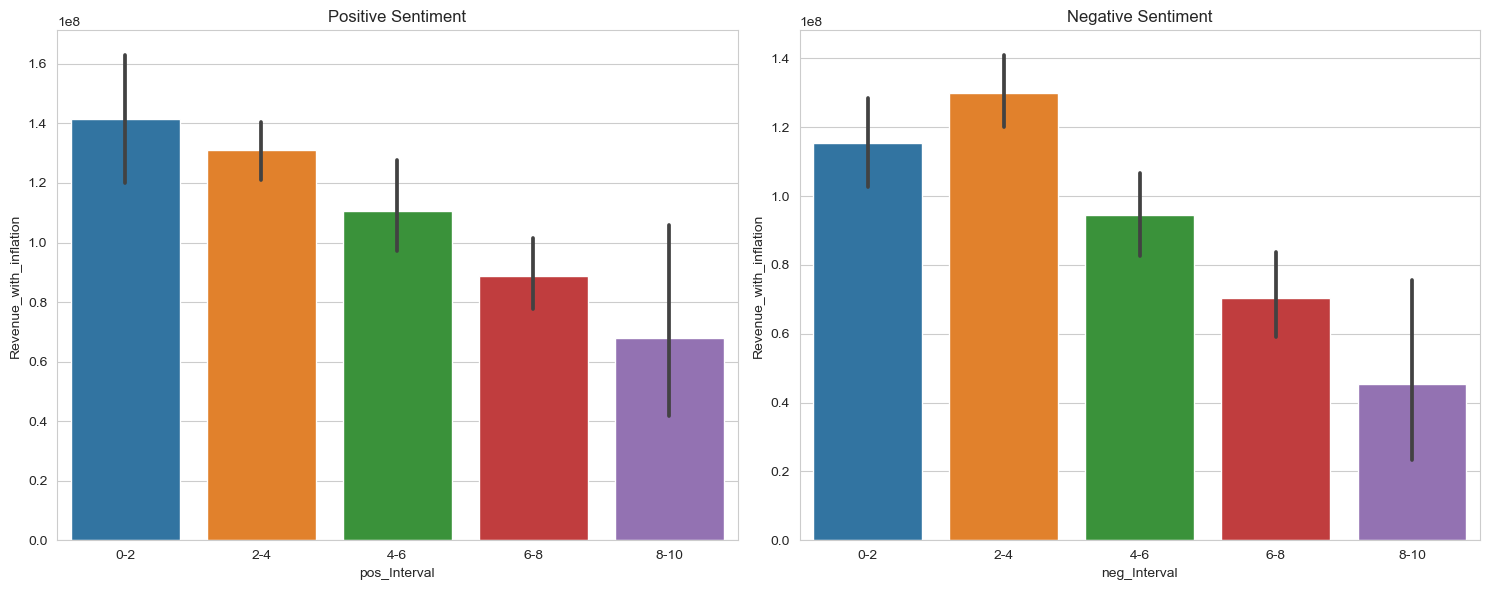

In [91]:
columns_of_interest = ['percentage of positive words', 'percentage of negative words', 'percentage of neutral words', 'Revenue_with_inflation']
data_to_plot = pos_neg_df[columns_of_interest]

# Set the figure size for the plot
plt.figure(figsize=(15, 6))

# Create subplots in a horizontal arrangement
plt.subplot(1, 2, 1)
pos_neg_df['pos_Interval'] = pd.cut(pos_neg_df['percentage of positive words'], bins=[0, 0.02, 0.04, 0.05, 0.08, 0.1], labels=['0-2', '2-4', '4-6', '6-8', '8-10'])

sns.barplot(x='pos_Interval', y='Revenue_with_inflation', data=pos_neg_df, ci=95)
plt.title('Positive Sentiment')

plt.subplot(1, 2, 2)
pos_neg_df['neg_Interval'] = pd.cut(pos_neg_df['percentage of negative words'], bins=[0, 0.02, 0.04, 0.05, 0.08, 0.1], labels=['0-2', '2-4', '4-6', '6-8', '8-10'])

sns.barplot(x='neg_Interval', y='Revenue_with_inflation', data=pos_neg_df, ci=95)
plt.title('Negative Sentiment')



# Adjust layout for better presentation
plt.tight_layout()

# Show the plots
plt.show()

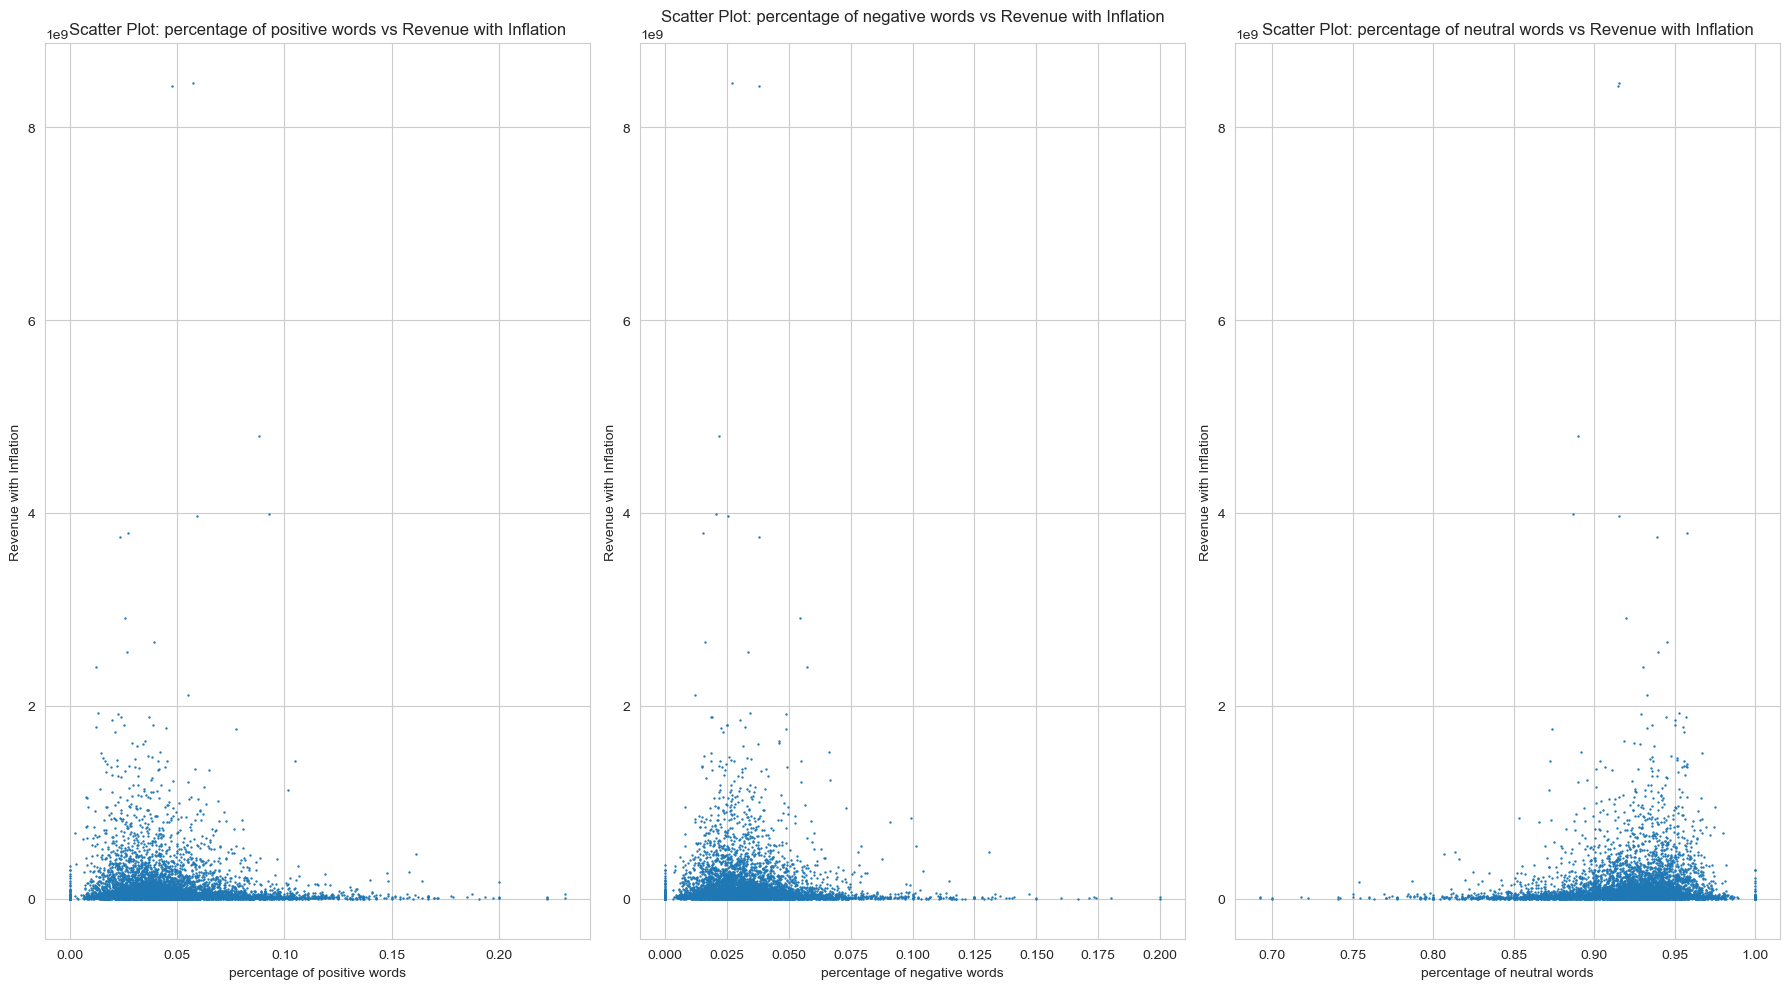

In [92]:
# Example x-axis labels
x_axis = ["percentage of positive words", "percentage of negative words", "percentage of neutral words"]

# Create a figure with six subplots (2 rows and 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

# Flatten the 2D array of axes for easier indexing in the loop
axes = axes.flatten()

# Loop through each subplot
for i in range(len(x_axis)):
    # Scatter plot for 'percentage of positive words' vs 'Revenue with inflation'
    axes[i].scatter(pos_neg_df[x_axis[i]], pos_neg_df['Revenue_with_inflation'], s=0.5)
    axes[i].set_xlabel(x_axis[i])
    axes[i].set_ylabel('Revenue with Inflation')
    axes[i].set_title(f'Scatter Plot: {x_axis[i]} vs Revenue with Inflation')

# Adjust layout for better presentation
plt.tight_layout()

# Show the plots
plt.show()

In [93]:
# From the graph, we can extract a threshold for the positive percentage of words
pos_thres = 0.1

# Filter movies which have positive percentage of words > 10%
pos_total_df = pos_neg_df[pos_neg_df["percentage of positive words"]> pos_thres]
# Filter movies which have positive percentage of words <= 10%
non_pos_total_df = pos_neg_df[pos_neg_df["percentage of positive words"]<= pos_thres]

# From the graph, we can extract a threshold for the negative percentage of words
neg_thres = 0.075
# Filter movies which have negative percentage of words > 7.5%
neg_total_df = pos_neg_df[pos_neg_df["percentage of negative words"]> neg_thres]
# Filter movies which have positive percentage of words <= 7.5%
non_neg_total_df = pos_neg_df[pos_neg_df["percentage of negative words"]<= neg_thres]

In [94]:
from scipy.stats import ttest_ind

# Extract the numerical data from the DataFrames
data_pos_total = pos_total_df["log_revenues"]
data_non_pos_total = non_pos_total_df["log_revenues"]

# Run the t-test
t_statistic, p_value = ttest_ind(data_pos_total, data_non_pos_total)

# Print the results
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

# Check the significance level
alpha = 0.05
if p_value < alpha:
    print('The difference is statistically significant (reject the null hypothesis)')
else:
    print('The difference is not statistically significant (fail to reject the null hypothesis)')

T-statistic: -8.995709969812653
P-value: 2.9284733056463813e-19
The difference is statistically significant (reject the null hypothesis)


In [95]:
# Extract the numerical data from the DataFrames
data_neg_total = neg_total_df["log_revenues"]
data_non_neg_total = non_neg_total_df["log_revenues"]

# Run the t-test
t_statistic, p_value = ttest_ind(data_neg_total, data_non_neg_total)

# Print the results
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

# Check the significance level
alpha = 0.05
if p_value < alpha:
    print('The difference is statistically significant (reject the null hypothesis)')
else:
    print('The difference is not statistically significant (fail to reject the null hypothesis)')

T-statistic: -7.806942685490667
P-value: 6.650874184964662e-15
The difference is statistically significant (reject the null hypothesis)


# Soup regression formula (in progress)

In [56]:
# List of columns to drop from each dataframe
#columns_to_drop = ['Revenue_with_inflation', 'log_revenues']

# Drop specified columns from each dataframe
years_df.drop(['Revenue_with_inflation', 'log_revenues', 'Year'], axis=1, inplace=True, errors='ignore')
movie_runtime_df.drop(['Revenue_with_inflation', 'log_revenues', 'Movie_runtime'], axis=1, inplace=True, errors='ignore')
movie_genres_reg_df.drop(['Revenue_with_inflation', 'log_revenues'], axis=1, inplace=True, errors='ignore')
movie_languages_reg_df.drop(['Revenue_with_inflation', 'log_revenues'], axis=1, inplace=True, errors='ignore')
movie_countries_reg_df.drop(['Revenue_with_inflation', 'log_revenues'], axis=1, inplace=True, errors='ignore')
gender_df.drop(['Revenue_with_inflation', 'Movie_name', 'log_revenues', 'Percentage_Women'], axis=1, inplace=True, errors='ignore')

In [57]:
# Merge dataframes as before
merged_df = pd.merge(months_df, gender_df, on='Wikipedia_movie_ID', how='inner')
merged_df = pd.merge(merged_df, years_df, on='Wikipedia_movie_ID', how='inner')
merged_df = pd.merge(merged_df, movie_actors_df, on='Wikipedia_movie_ID', how='inner')
merged_df = pd.merge(merged_df, movie_runtime_df, on='Wikipedia_movie_ID', how='inner')
merged_df = pd.merge(merged_df, movie_genres_reg_df, on='Wikipedia_movie_ID', how='inner')
merged_df = pd.merge(merged_df, movie_languages_reg_df, on='Wikipedia_movie_ID', how='inner')
merged_df = pd.merge(merged_df, movie_countries_reg_df, on='Wikipedia_movie_ID', how='inner')

In [58]:
# List of columns to one-hot encode
columns_to_encode = ['Month', 'group', 'year_intervals', 'Interval']

# Perform one-hot encoding
encoded_df = pd.get_dummies(merged_df, columns=columns_to_encode)
encoded_df.drop(columns=['Wikipedia_movie_ID', 'Revenue_with_inflation', 'log_revenues'], inplace=True, errors='ignore')

# Drop the original columns after encoding
merged_df.drop(columns=columns_to_encode, inplace=True, errors='ignore')

# Concatenate the original dataframe with the encoded columns
encoded_df = pd.concat([merged_df, encoded_df], axis=1)
columns_to_drop = ['Wikipedia_movie_ID','Revenue_with_inflation']
encoded_df.drop(columns = columns_to_drop,inplace=True,errors='ignore')

We use random forest to make our formula

In [59]:
model = ske.RandomForestRegressor(n_estimators=1000, random_state=42, bootstrap=True, max_features='sqrt', max_depth=80, n_jobs=-1)
X = encoded_df.drop(['log_revenues'], axis=1)
y = encoded_df['log_revenues']

In [60]:
model.fit(X,y)

# Make predictions on the test element
y_pred = model.predict(X)

C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(

In [61]:
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Display the regression report
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)


Mean Squared Error (MSE): 0.3436091520287551
Mean Absolute Error (MAE): 0.4302123517896316
R-squared (R2): 0.9173512380262919


C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

In [62]:
residuals = y - y_pred
#merge y with merged_df
merged_df['guess diference'] = residuals
merged_df['guess'] = y_pred


In [63]:
merged_df

,Wikipedia_movie_ID,Revenue_with_inflation,log_revenues,top5_actors,top20_actors,top50_actors,Crime Thriller,Science Fiction,Romance Film,Family Film,...,South Korea,Canada,United Kingdom,Germany,United States of America,France,Japan,other_countries,guess diference,guess
0,975900,2.315268e+07,16.957621,0,0,2,False,True,False,False,...,False,False,False,False,True,False,False,False,-0.643584,17.601205
1,156558,4.855272e+07,17.698161,0,0,1,False,False,False,False,...,False,False,False,False,True,False,False,False,-0.116167,17.814328
2,5566878,7.559723e+06,15.838345,0,0,0,False,False,True,False,...,False,False,False,False,True,False,False,False,-0.047901,15.886246
3,570743,1.176346e+08,18.583094,1,0,3,False,False,True,False,...,False,True,False,True,True,False,False,True,0.453878,18.129215
4,366111,2.331158e+08,19.267046,0,1,2,False,False,True,False,...,False,False,False,True,True,False,False,False,0.512250,18.754795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6600,25442375,4.960254e+07,17.719553,0,0,0,False,False,False,False,...,False,False,False,False,True,False,False,False,0.665631,17.053921
6601,68388,1.653418e+07,16.620940,0,0,0,False,False,True,False,...,False,False,False,False,True,False,False,False,-0.202133,16.823074
6602,1995966,8.557164e+07,18.264864,0,0,0,False,False,False,False,...,False,False,False,False,True,False,False,False,0.290673,17.974191
6603,24587655,2.344663e+07,16.970237,0,0,0,False,False,True,False,...,False,False,False,False,True,False,False,False,-0.282559,17.252796


C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

<Axes: xlabel='log_revenues', ylabel='guess'>

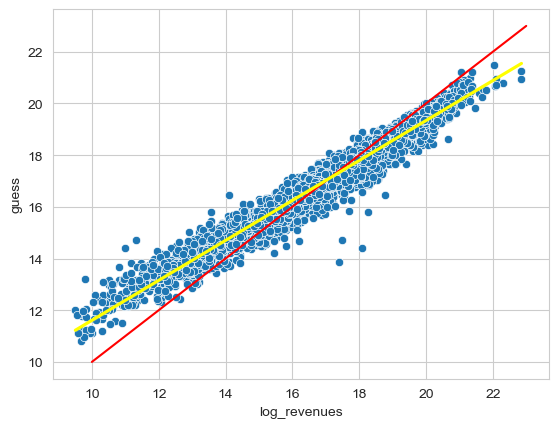

In [64]:
# the guess vs the real log_revenues
sns.scatterplot(data=merged_df, x='log_revenues', y='guess')
# on the same graph add a line y=x and a line fitting the points
sns.lineplot(x=np.linspace(10, 23, 100), y=np.linspace(10, 23, 100), color='red')
sns.regplot(data=merged_df, x='log_revenues', y='guess', scatter=False, color='yellow')


C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='guess diference', ylabel='Count'>

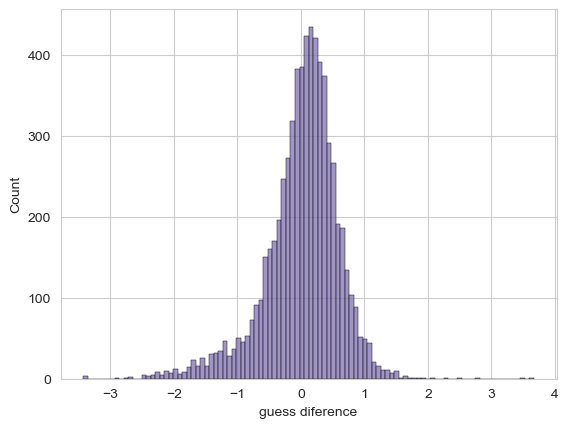

In [65]:
#plot the distribution of the residuals
sns.histplot(data=merged_df, x='guess diference', bins=100, color=sns.color_palette("deep")[4], edgecolor='black')

In [66]:
outliers_film_df = pd.merge(merged_df, movie_with_inflation, on='Wikipedia_movie_ID', how='inner')[['Movie_name', 'Movie_release_date','Revenue_with_inflation_y', 'log_revenues_y', 'guess', 'guess diference']]
outliers_film_df

,Movie_name,Movie_release_date,Revenue_with_inflation_y,log_revenues_y,guess,guess diference
0,Ghosts of Mars,2001-08-24,2.315268e+07,16.957621,17.601205,-0.643584
1,Baby Boy,2001-06-27,4.855272e+07,17.698161,17.814328,-0.116167
2,Tortilla Soup,2001-08-24,7.559723e+06,15.838345,15.886246,-0.047901
3,Down to Earth,2001-02-12,1.176346e+08,18.583094,18.129215,0.453878
4,Shallow Hal,2001-11-01,2.331158e+08,19.267046,18.754795,0.512250
...,...,...,...,...,...,...
6600,Aloma of the South Seas,1926-05-16,4.960254e+07,17.719553,17.053921,0.665631
6601,The General,1926-12-31,1.653418e+07,16.620940,16.823074,-0.202133
6602,The Singing Fool,1928-08-17,8.557164e+07,18.264864,17.974191,0.290673
6603,A Woman of Affairs,1928-12-15,2.344663e+07,16.970237,17.252796,-0.282559
